In [52]:
import os
import glob
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Plotting style
sns.set_theme(style='whitegrid')

# ===========================
# Load and clean the data
# ===========================
base_dir = "analysis/abide"
selected_rois = ['Temporal Region',
                 'Prefrontal Cortex',
                 'Cingulate Cortex',
                 'Amygdala',
                 'Hippocampus',
                 'Insula',
                 'Cerebellum'
]


def load_and_filter_data(files, group_name, selected_rois=None):
    df_list = []
    for file in files:
        df = pd.read_csv(file)
        df['source_file'] = file
        df['group'] = group_name
        if selected_rois is not None:
            df = df[df['Region'].isin(selected_rois)]
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)


asd_files = glob.glob(os.path.join(base_dir, "*", "patient", "metrics", "abide_roi_metrics.csv"))
asd_data = load_and_filter_data(asd_files, 'ASD', selected_rois)

control_files = glob.glob(os.path.join(base_dir, "*", "control", "metrics", "abide_roi_metrics.csv"))
control_data = load_and_filter_data(control_files, 'Control', selected_rois)

all_data = pd.concat([asd_data, control_data], ignore_index=True)
all_data.dropna(inplace=True)


# Extract age bin from file path
def extract_age_bin(path):
    match = re.search(r"abide[\\/](.*?)[\\/]", path)
    return match.group(1) if match else "unknown"


all_data['age_bin'] = all_data['source_file'].apply(extract_age_bin)
age_bin_order = ["11-", "12_17", "18_25", "25+"]
all_data['age_bin'] = pd.Categorical(all_data['age_bin'], categories=age_bin_order, ordered=True)


# Pivot data by subject
def create_pivot(df):
    subject_ages = df.groupby('SubjectID')['Age'].first()
    subject_bins = df.groupby('SubjectID')['age_bin'].first()
    pivot_df = df.pivot_table(index='SubjectID', columns='Region', values=['Closeness', 'Clustering', 'Degree'])
    pivot_df.columns = [f'{metric}_{roi}' for metric, roi in pivot_df.columns]
    pivot_df.reset_index(inplace=True)
    pivot_df['Age'] = pivot_df['SubjectID'].map(subject_ages)
    pivot_df['age_bin'] = pivot_df['SubjectID'].map(subject_bins)
    return pivot_df


asd_pivot_df = create_pivot(all_data[all_data['group'] == 'ASD']).dropna()
asd_pivot_df['group'] = 'ASD'

control_pivot_df = create_pivot(all_data[all_data['group'] == 'Control']).dropna()
control_pivot_df['group'] = 'Control'

In [53]:
# ===========================
# HMM per ogni metrica (ASD)
# ===========================

from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm

def train_hmm_by_metric(df, metrics, n_states=2, n_seeds=10, prefix='ASD'):
    for metric in metrics:
        print(f"\n🔍 Addestramento HMM su metrica: {metric}")

        metric_cols = [col for col in df.columns if col.startswith(metric)]
        X = df[metric_cols].values

        # Rimuove feature con varianza nulla
        variances = X.var(axis=0)
        X = X[:, variances > 0]
        valid_cols = [col for i, col in enumerate(metric_cols) if variances[i] > 0]

        if X.shape[1] == 0:
            print(f"⚠️ Nessuna feature valida per {metric}")
            continue

        # Standardizzazione
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # HMM multiseed
        best_model = None
        best_score = -np.inf

        for seed in range(n_seeds):
            try:
                model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=400, random_state=seed)
                model.fit(X_scaled)
                score = model.score(X_scaled)
                if not np.isnan(score) and score > best_score:
                    best_model = model
                    best_score = score
            except Exception as e:
                print(f"  ⚠️ Errore HMM (seed {seed}): {e}")

        if best_model is not None:
            hidden_states = best_model.predict(X_scaled)
            state_col = f"{prefix}_{metric}_state"
            df[state_col] = hidden_states
            print(f"✅ Colonna '{state_col}' aggiunta.")
        else:
            print(f"❌ Nessun modello HMM valido per {metric}")

# Applica su ASD
metrics = ['Closeness', 'Clustering', 'Degree']
train_hmm_by_metric(asd_pivot_df, metrics, n_states=3, n_seeds=10, prefix='ASD')



🔍 Addestramento HMM su metrica: Closeness
✅ Colonna 'ASD_Closeness_state' aggiunta.

🔍 Addestramento HMM su metrica: Clustering
✅ Colonna 'ASD_Clustering_state' aggiunta.

🔍 Addestramento HMM su metrica: Degree
✅ Colonna 'ASD_Degree_state' aggiunta.


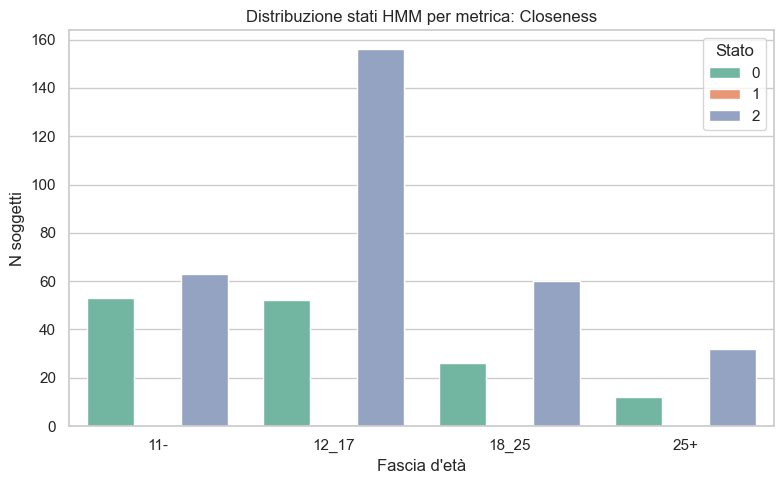

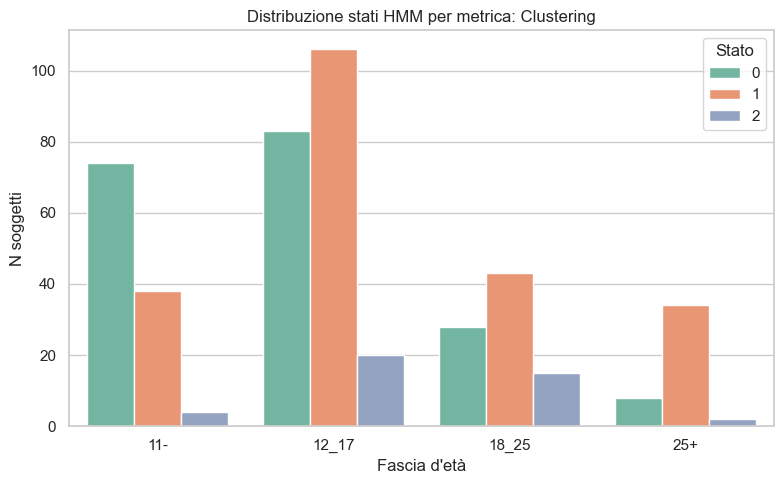

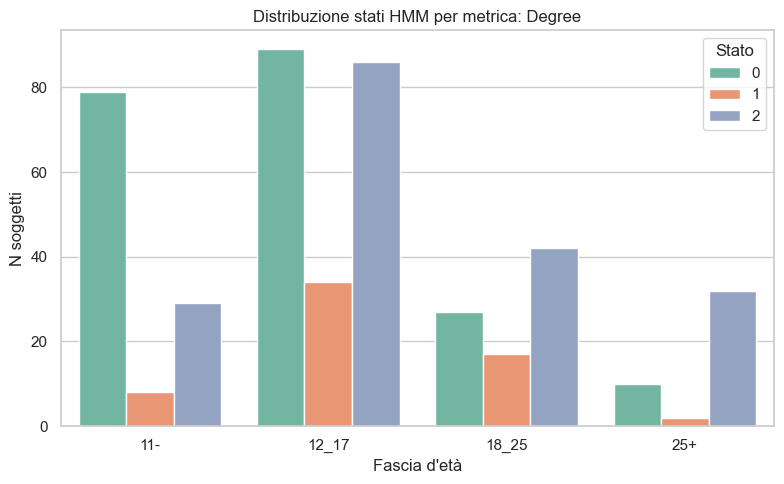

In [54]:
# Visualizza distribuzione degli stati per ogni metrica
for metric in metrics:
    state_col = f"ASD_{metric}_state"
    if state_col in asd_pivot_df.columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=asd_pivot_df, x='age_bin', hue=state_col, palette='Set2')
        plt.title(f'Distribuzione stati HMM per metrica: {metric}')
        plt.xlabel('Fascia d\'età')
        plt.ylabel('N soggetti')
        plt.legend(title='Stato')
        plt.tight_layout()
        plt.show()


In [55]:
from collections import Counter

def simulate_trajectories(df, state_column, age_bins, n_bootstraps=1000):
    state_trajectories = []

    for b in range(n_bootstraps):
        trajectory = []
        valid = True
        for bin_label in age_bins:
            candidates = df[df['age_bin'] == bin_label]
            if candidates.empty or state_column not in candidates.columns:
                valid = False
                break
            chosen = candidates.sample(n=1, random_state=b)
            state = chosen[state_column].values[0]
            trajectory.append(state)
        if valid:
            state_trajectories.append(tuple(trajectory))

    return state_trajectories


In [56]:
age_bins = age_bin_order  # ["11-", "12_17", "18_25", "25+"]
n_bootstraps = 1000

trajectory_dict = {}

for metric in metrics:
    state_col = f"ASD_{metric}_state"
    if state_col in asd_pivot_df.columns:
        print(f"\n📈 Simulazione traiettorie per metrica: {metric}")
        trajectories = simulate_trajectories(asd_pivot_df, state_col, age_bins, n_bootstraps=n_bootstraps)
        counts = Counter(trajectories)
        most_common = counts.most_common(5)
        print("Traiettorie più frequenti:")
        for i, (traj, count) in enumerate(most_common):
            print(f"  {i+1}. {traj} (frequenza: {count})")
        trajectory_dict[metric] = trajectories



📈 Simulazione traiettorie per metrica: Closeness
Traiettorie più frequenti:
  1. (2, 2, 2, 2) (frequenza: 210)
  2. (0, 2, 2, 2) (frequenza: 163)
  3. (2, 2, 0, 2) (frequenza: 92)
  4. (0, 2, 0, 2) (frequenza: 78)
  5. (2, 2, 2, 0) (frequenza: 76)

📈 Simulazione traiettorie per metrica: Clustering
Traiettorie più frequenti:
  1. (0, 1, 1, 1) (frequenza: 126)
  2. (0, 0, 1, 1) (frequenza: 85)
  3. (0, 1, 0, 1) (frequenza: 79)
  4. (1, 1, 1, 1) (frequenza: 70)
  5. (0, 0, 0, 1) (frequenza: 58)

📈 Simulazione traiettorie per metrica: Degree
Traiettorie più frequenti:
  1. (0, 2, 2, 2) (frequenza: 116)
  2. (0, 0, 2, 2) (frequenza: 90)
  3. (0, 2, 0, 2) (frequenza: 60)
  4. (0, 0, 0, 2) (frequenza: 56)
  5. (2, 2, 2, 2) (frequenza: 43)



🔄 Transizioni HMM - metrica: Closeness


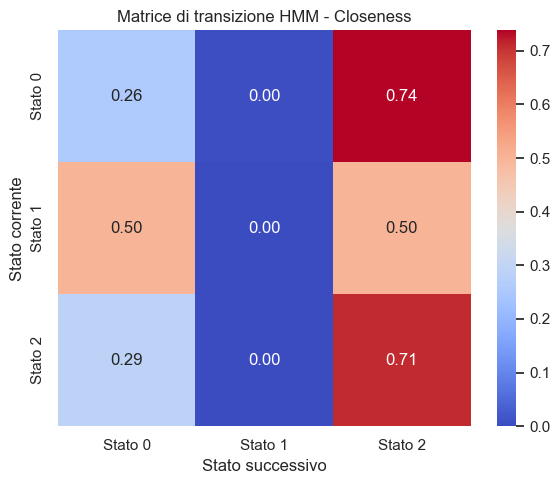


🔄 Transizioni HMM - metrica: Clustering


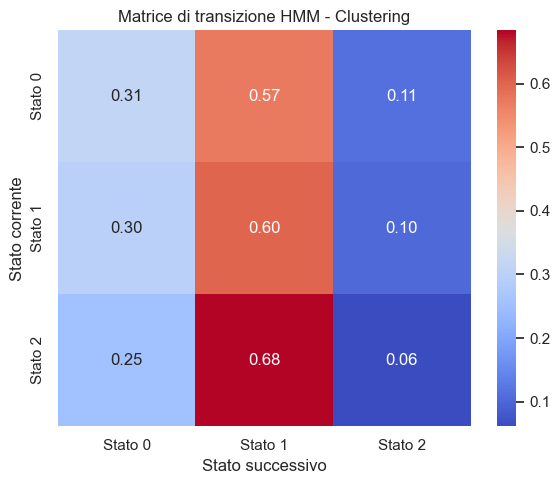


🔄 Transizioni HMM - metrica: Degree


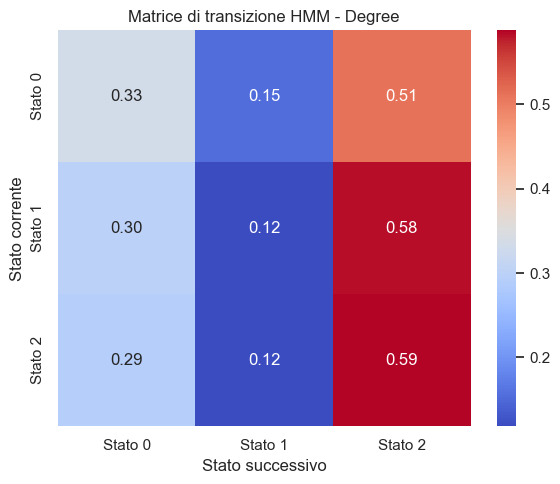

In [58]:
for metric, trajectories in trajectory_dict.items():
    print(f"\n🔄 Transizioni HMM - metrica: {metric}")
    n_states = 3
    transition_counts = np.zeros((n_states, n_states), dtype=int)

    for traj in trajectories:
        for (s1, s2) in zip(traj[:-1], traj[1:]):
            transition_counts[s1, s2] += 1

    transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(transition_probs, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=[f'Stato {i}' for i in range(n_states)],
                yticklabels=[f'Stato {i}' for i in range(n_states)])
    plt.title(f"Matrice di transizione HMM - {metric}")
    plt.xlabel("Stato successivo")
    plt.ylabel("Stato corrente")
    plt.tight_layout()
    plt.show()


In [ ]:
# ===========================
# HMM for ASD patients
# ===========================
roi_columns_asd = [col for col in asd_pivot_df.columns if any(m in col for m in ['Closeness', 'Clustering', 'Degree'])]
X_asd = asd_pivot_df[roi_columns_asd].values

# Remove zero-variance features
variances = X_asd.var(axis=0)
X_asd = X_asd[:, variances > 0]
roi_columns_asd = [col for i, col in enumerate(roi_columns_asd) if variances[i] > 0]

# Scale data
scaler_asd = StandardScaler()
X_asd_scaled = scaler_asd.fit_transform(X_asd)

# Fit HMM with multiple seeds and keep the best
best_model_asd = None
best_score = -np.inf
n_states = 2

for seed in range(10):
    try:
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=400, random_state=seed)
        model.fit(X_asd_scaled)
        score = model.score(X_asd_scaled)
        if not np.isnan(score) and score > best_score:
            best_model_asd = model
            best_score = score
    except Exception as e:
        print(f"HMM error for seed {seed}: {e}")

if best_model_asd is not None:
    hidden_states_asd = best_model_asd.predict(X_asd_scaled)
    asd_pivot_df['ASD_severity_state'] = hidden_states_asd
else:
    print("No valid HMM model found for ASD patients.")

In [ ]:
# ===========================
# Simulate pseudo-longitudinal trajectories (bootstrapping)
# ===========================
from collections import Counter

N_BOOTSTRAPS = 1000
age_bins = age_bin_order
state_trajectories = []

for b in range(N_BOOTSTRAPS):
    trajectory = []
    valid = True
    for bin_label in age_bins:
        candidates = asd_pivot_df[asd_pivot_df['age_bin'] == bin_label]
        if candidates.empty:
            valid = False
            break
        chosen = candidates.sample(n=1, random_state=b)
        features = chosen[roi_columns_asd].values
        features_scaled = scaler_asd.transform(features)
        state = best_model_asd.predict(features_scaled)[0]
        trajectory.append(state)
    if valid:
        state_trajectories.append(tuple(trajectory))

In [ ]:
# ===========================
# Show most frequent trajectories
# ===========================
trajectory_counts = Counter(state_trajectories)
most_common = trajectory_counts.most_common(10)

print("\nMost frequent state trajectories:")
for i, (traj, count) in enumerate(most_common):
    print(f"{i + 1}. {traj} (frequency: {count})")

In [ ]:
# ===========================
# Transition matrix
# ===========================
transition_counts = np.zeros((n_states, n_states), dtype=int)

for traj in state_trajectories:
    for (s1, s2) in zip(traj[:-1], traj[1:]):
        transition_counts[s1, s2] += 1

transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)

# Visualize transition matrix
plt.figure(figsize=(7, 5))
sns.heatmap(transition_probs, annot=True, fmt=".2f", cmap='Oranges',
            xticklabels=[f'State {i}' for i in range(n_states)],
            yticklabels=[f'State {i}' for i in range(n_states)])
plt.title("Transition Matrix for Bootstrapped ASD Trajectories")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.tight_layout()
plt.show()

In [ ]:
# ===========================
# Visualize HMM state distribution across age bins
# ===========================
plt.figure(figsize=(10, 6))
sns.countplot(data=asd_pivot_df, x='age_bin', hue='ASD_severity_state', palette='Set2')
plt.title('Distribution of ASD Severity States by Age')
plt.xlabel('Age Bin')
plt.ylabel('Number of Subjects')
plt.legend(title='State')
plt.tight_layout()
plt.show()

In [ ]:
# ===========================
# HMM for Control patients
# ===========================
roi_columns_ctrl = [col for col in control_pivot_df.columns if any(m in col for m in ['Closeness', 'Clustering', 'Degree'])]
X_ctrl = control_pivot_df[roi_columns_ctrl].values

# Remove zero-variance features
variances_ctrl = X_ctrl.var(axis=0)
X_ctrl = X_ctrl[:, variances_ctrl > 0]
roi_columns_ctrl = [col for i, col in enumerate(roi_columns_ctrl) if variances_ctrl[i] > 0]

# Scale data
scaler_ctrl = StandardScaler()
X_ctrl_scaled = scaler_ctrl.fit_transform(X_ctrl)

# Fit HMM
best_model_ctrl = None
best_score_ctrl = -np.inf

for seed in range(10):
    try:
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=400, random_state=seed)
        model.fit(X_ctrl_scaled)
        score = model.score(X_ctrl_scaled)
        if not np.isnan(score) and score > best_score_ctrl:
            best_model_ctrl = model
            best_score_ctrl = score
    except Exception as e:
        print(f"HMM error (Control) for seed {seed}: {e}")

if best_model_ctrl is not None:
    hidden_states_ctrl = best_model_ctrl.predict(X_ctrl_scaled)
    control_pivot_df['Control_state'] = hidden_states_ctrl
else:
    print("No valid HMM model found for Control group.")


In [ ]:
control_trajectories = []

for b in range(N_BOOTSTRAPS):
    trajectory = []
    valid = True
    for bin_label in age_bins:
        candidates = control_pivot_df[control_pivot_df['age_bin'] == bin_label]
        if candidates.empty:
            valid = False
            break
        chosen = candidates.sample(n=1, random_state=b)
        features = chosen[roi_columns_ctrl].values
        features_scaled = scaler_ctrl.transform(features)
        state = best_model_ctrl.predict(features_scaled)[0]
        trajectory.append(state)
    if valid:
        control_trajectories.append(tuple(trajectory))


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=control_pivot_df, x='age_bin', hue='Control_state', palette='Set1')
plt.title('Distribuzione degli stati latenti (HMM) nei soggetti di controllo')
plt.xlabel('Fascia d’età')
plt.ylabel('Numero di soggetti')
plt.legend(title='Stato latente')
plt.tight_layout()
plt.show()

In [ ]:
def compute_transition_matrix(trajectories, n_states):
    transition_counts = np.zeros((n_states, n_states), dtype=int)
    for traj in trajectories:
        for (s1, s2) in zip(traj[:-1], traj[1:]):
            transition_counts[s1, s2] += 1
    with np.errstate(divide='ignore', invalid='ignore'):
        transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)
        transition_probs = np.nan_to_num(transition_probs)
    return transition_probs
# Calcola le due matrici
trans_matrix_asd = compute_transition_matrix(state_trajectories, n_states)
trans_matrix_ctrl = compute_transition_matrix(control_trajectories, n_states)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.heatmap(trans_matrix_asd, annot=True, fmt=".2f", cmap='Oranges',
            xticklabels=[f'Stato {i}' for i in range(n_states)],
            yticklabels=[f'Stato {i}' for i in range(n_states)],
            ax=axs[0])
axs[0].set_title("ASD - Matrice di Transizione")
axs[0].set_xlabel("Stato successivo")
axs[0].set_ylabel("Stato attuale")

sns.heatmap(trans_matrix_ctrl, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=[f'Stato {i}' for i in range(n_states)],
            yticklabels=[f'Stato {i}' for i in range(n_states)],
            ax=axs[1])
axs[1].set_title("Controlli - Matrice di Transizione")
axs[1].set_xlabel("Stato successivo")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
# Calcola la differenza assoluta tra le medie degli stati
means_asd = best_model_asd.means_
feature_diffs_asd = np.abs(means_asd[0] - means_asd[1])

# Associa ai nomi delle feature
asd_feature_diff_df = pd.DataFrame({
    'Feature': roi_columns_asd,
    'Difference': feature_diffs_asd
}).sort_values(by='Difference', ascending=False)

# Mostra le top N
top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=asd_feature_diff_df.head(top_n), x='Difference', y='Feature', palette='Reds_r')
plt.title(f"Top {top_n} ROI/metriche che differenziano gli stati HMM negli ASD")
plt.xlabel("Differenza assoluta media tra stati")
plt.tight_layout()
plt.show()


In [ ]:
# Calcola la differenza assoluta tra le medie degli stati per i controlli
means_ctrl = best_model_ctrl.means_
feature_diffs_ctrl = np.abs(means_ctrl[0] - means_ctrl[1])

# Associa ai nomi delle feature
ctrl_feature_diff_df = pd.DataFrame({
    'Feature': roi_columns_ctrl,
    'Difference': feature_diffs_ctrl
}).sort_values(by='Difference', ascending=False)

# Mostra le top N
top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=ctrl_feature_diff_df.head(top_n), x='Difference', y='Feature', palette='Blues_r')
plt.title(f"Top {top_n} ROI/metriche che differenziano gli stati HMM nei Controlli")
plt.xlabel("Differenza assoluta media tra stati")
plt.tight_layout()
plt.show()
